**Importação das bibliotecas**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import statistics as sts
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, classification_report, recall_score, precision_recall_curve

**Carregando a base de dados**

In [ ]:
base = pd.read_csv('karolinska_paper2_data_2021_0915.xlsx - clean.csv')

**EDA e tratamento da base de dados**

In [ ]:
#Visualizando a base no geral

base.head()

,gender_bin,age_days_above_60_integer,bmi,Glugose,HDLChol,LDLChol,Insulin,Triglycerides,SMOKE,CRP__mg_L_,CHOL,BTSYSM,BTDIASM,diabetes,HYPERTON,antiPC_igm,antiPc_igg,antiPc_igg1,antiPC_igg2,cvd,MI,ANGINA,STROKE
0,0,76,28.53,6.9,1.40,3.8,11.9,0.7,0.0,1.30,5.5,134.5,81.5,0,0,38.920,64.393685,126.299046,40.033501,NaN,NaN,NaN,1.0
1,0,80,20.84,5.5,1.66,4.7,12.0,0.7,2.0,0.63,6.7,116.5,74.0,0,0,74.360,503.762177,407.317073,932.495812,NaN,NaN,NaN,NaN
2,0,87,26.66,5.8,1.47,4.6,15.2,1.4,0.0,1.40,6.7,150.0,88.0,0,0,39.795,195.783132,87.910923,119.430486,NaN,NaN,NaN,NaN
3,0,79,29.51,5.5,0.97,2.8,10.4,1.5,0.0,1.20,4.5,129.5,80.0,0,0,200.200,305.572289,168.504772,413.902848,NaN,NaN,NaN,NaN
4,0,79,25.56,5.0,1.03,3.5,11.7,1.0,0.0,0.99,5.0,135.0,85.0,0,1,59.330,254.216867,375.291623,839.698493,NaN,NaN,NaN,NaN


In [ ]:
#Verificando a quantidade de colunas e linhas da base de dados

base.shape

(844, 23)

In [ ]:
#Verificando a quantidade de valores nulos em cada coluna

base.isnull().sum()

gender_bin                     0
age_days_above_60_integer      0
bmi                            0
Glugose                        0
HDLChol                        0
LDLChol                        0
Insulin                        0
Triglycerides                  0
SMOKE                         14
CRP__mg_L_                    12
CHOL                           0
BTSYSM                         1
BTDIASM                        1
diabetes                       0
HYPERTON                       0
antiPC_igm                    12
antiPc_igg                    15
antiPc_igg1                   15
antiPC_igg2                   15
cvd                          682
MI                           767
ANGINA                       759
STROKE                       795
dtype: int64

In [ ]:
#Porcentagem dos valores nulos de cada coluna

(base.isnull().sum() / len(base['gender_bin'])) * 100

gender_bin                    0.000000
age_days_above_60_integer     0.000000
bmi                           0.000000
Glugose                       0.000000
HDLChol                       0.000000
LDLChol                       0.000000
Insulin                       0.000000
Triglycerides                 0.000000
SMOKE                         1.658768
CRP__mg_L_                    1.421801
CHOL                          0.000000
BTSYSM                        0.118483
BTDIASM                       0.118483
diabetes                      0.000000
HYPERTON                      0.000000
antiPC_igm                    1.421801
antiPc_igg                    1.777251
antiPc_igg1                   1.777251
antiPC_igg2                   1.777251
cvd                          80.805687
MI                           90.876777
ANGINA                       89.928910
STROKE                       94.194313
dtype: float64

In [ ]:
#Eliminando valores nulos

base = base.loc[pd.notnull(base['SMOKE'])] 
base = base.loc[pd.notnull(base['CRP__mg_L_'])] 
base = base.loc[pd.notnull(base['antiPC_igm'])]
base = base.loc[pd.notnull(base['antiPc_igg'])]
base = base.loc[pd.notnull(base['antiPc_igg1'])]
base = base.loc[pd.notnull(base['antiPC_igg2'])]
base = base.loc[pd.notnull(base['BTSYSM'])] 

base.isnull().sum()

gender_bin                     0
age_days_above_60_integer      0
bmi                            0
Glugose                        0
HDLChol                        0
LDLChol                        0
Insulin                        0
Triglycerides                  0
SMOKE                          0
CRP__mg_L_                     0
CHOL                           0
BTSYSM                         0
BTDIASM                        0
diabetes                       0
HYPERTON                       0
antiPC_igm                     0
antiPc_igg                     0
antiPc_igg1                    0
antiPC_igg2                    0
cvd                          655
MI                           740
ANGINA                       729
STROKE                       766
dtype: int64

In [ ]:
#Considerando que as colunas  previsores "verdes" possuem apenas valores 1 e nulo, substituimos os valores nulos por 0

base = base.fillna(0)

In [ ]:
base.isnull().sum()

gender_bin                   0
age_days_above_60_integer    0
bmi                          0
Glugose                      0
HDLChol                      0
LDLChol                      0
Insulin                      0
Triglycerides                0
SMOKE                        0
CRP__mg_L_                   0
CHOL                         0
BTSYSM                       0
BTDIASM                      0
diabetes                     0
HYPERTON                     0
antiPC_igm                   0
antiPc_igg                   0
antiPc_igg1                  0
antiPC_igg2                  0
cvd                          0
MI                           0
ANGINA                       0
STROKE                       0
dtype: int64

In [ ]:
#Após a eliminação dos valores nulos, foram deletadas 30 linhas da base de dados

base.shape

(814, 23)

In [ ]:
#Verificando os tipos de dados existentes no dataset

base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814 entries, 0 to 842
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender_bin                 814 non-null    int64  
 1   age_days_above_60_integer  814 non-null    int64  
 2   bmi                        814 non-null    float64
 3   Glugose                    814 non-null    float64
 4   HDLChol                    814 non-null    float64
 5   LDLChol                    814 non-null    float64
 6   Insulin                    814 non-null    float64
 7   Triglycerides              814 non-null    float64
 8   SMOKE                      814 non-null    float64
 9   CRP__mg_L_                 814 non-null    float64
 10  CHOL                       814 non-null    float64
 11  BTSYSM                     814 non-null    float64
 12  BTDIASM                    814 non-null    float64
 13  diabetes                   814 non-null    int64  

In [ ]:
# transformação das colunas a serem previstas em valores inteiros
base[['cvd','MI','ANGINA','STROKE']] = base[['cvd','MI','ANGINA','STROKE']].astype(int)

In [ ]:
#tipo de dados após a transformação
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814 entries, 0 to 842
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender_bin                 814 non-null    int64  
 1   age_days_above_60_integer  814 non-null    int64  
 2   bmi                        814 non-null    float64
 3   Glugose                    814 non-null    float64
 4   HDLChol                    814 non-null    float64
 5   LDLChol                    814 non-null    float64
 6   Insulin                    814 non-null    float64
 7   Triglycerides              814 non-null    float64
 8   SMOKE                      814 non-null    float64
 9   CRP__mg_L_                 814 non-null    float64
 10  CHOL                       814 non-null    float64
 11  BTSYSM                     814 non-null    float64
 12  BTDIASM                    814 non-null    float64
 13  diabetes                   814 non-null    int64  

In [ ]:
#Quantidade de valores únicos para cada atributo

base.nunique()

gender_bin                     2
age_days_above_60_integer    167
bmi                          590
Glugose                       80
HDLChol                      168
LDLChol                       51
Insulin                      215
Triglycerides                 48
SMOKE                          3
CRP__mg_L_                   163
CHOL                          62
BTSYSM                       183
BTDIASM                      100
diabetes                       2
HYPERTON                       2
antiPC_igm                   796
antiPc_igg                   813
antiPc_igg1                  801
antiPC_igg2                  808
cvd                            2
MI                             2
ANGINA                         2
STROKE                         2
dtype: int64

In [ ]:
#Separando a base de dados em atributos previsores e atributos a serem previstos (targets)
#Observamos que as colunas gender_bin, SMOKE, diabetes e HYPERTON possuiam baixa relevância como atributos previsores, desta forma, foram exlcluídos.
#No caso dos previsores, foi replicado um para cada target, visto que será necessário balanceamento no dataset para cada saida (cvd, MI, ANGINA, STROKE)

previsores_cvd = base.drop(['gender_bin','SMOKE','diabetes','HYPERTON','cvd','MI','ANGINA','STROKE'], axis=1)
previsores_MI = previsores_cvd
previsores_ANGINA = previsores_cvd
previsores_STROKE = previsores_cvd

targets = base[['cvd','MI','ANGINA','STROKE']]

#Separando as colunas da base targets

target_cvd = targets['cvd']
target_MI = targets['MI']
target_ANGINA = targets['ANGINA']
target_STROKE = targets['STROKE']

In [ ]:
#Visualizando os valores unicos dentro das colunas da base targets

cvd = targets['cvd'].unique()
MI = targets['MI'].unique()
ANGINA = targets['ANGINA'].unique()
STROKE = targets['STROKE'].unique()
print(f'cvd: {cvd}\n\nMI: {MI}\n\nANGINA: {ANGINA} \n\nSTROKE: {STROKE}')

cvd: [0 1]

MI: [0 1]

ANGINA: [0 1] 

STROKE: [1 0]


**Função para detecção de Outliers**

In [ ]:
def outliers_test(x):

    ################################################
    n = len(x)

    mean_x = np.mean(x)

    sd_x = np.std(x)

    numerator = max(abs(x-mean_x))

    g_calculated = numerator/sd_x


    ### Valor Calculado
    print("Grubbs Valor Calculado:", g_calculated)

    ################################################

    # Teste "T"
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)


    # Fórmula de Grubbs
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))


    ### Valor Crítico
    print("Grubbs Valor Crítico:", g_critical)
    
    
    
    ################################################

    # Avaliando o Resultado do Teste de Grubbs para confirmar se pode existir Outliers
    if g_critical > g_calculated:
       print("Para esta coluna , observamos que o valor calculado é menor que o valor Crítico. Aceitamos a Hipótese de que NÃO há outliers\n")
    else:
       print("Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers\n")


**Verificando a existência de Outliers na base previsores**

In [ ]:
#Verificando a coluna age_days_above_60_integer
outliers_test(previsores_cvd['age_days_above_60_integer'])

Grubbs Valor Calculado: 5.435228968495202
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna bmi
outliers_test(previsores_cvd['bmi'])

Grubbs Valor Calculado: 5.560744794997704
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna Glugose
outliers_test(previsores_cvd['Glugose'])

Grubbs Valor Calculado: 7.141003725175974
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna HDLChol
outliers_test(previsores_cvd['HDLChol'])

Grubbs Valor Calculado: 4.405713173425279
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna LDLChol
outliers_test(previsores_cvd['LDLChol'])

Grubbs Valor Calculado: 3.498775936802984
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é menor que o valor Crítico. Aceitamos a Hipótese de que NÃO há outliers



In [ ]:
#Verificando a coluna Insulin
outliers_test(previsores_cvd['Insulin'])

Grubbs Valor Calculado: 8.462882299770893
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna Triglycerides
outliers_test(previsores_cvd['Triglycerides'])

Grubbs Valor Calculado: 7.246180728165582
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna CRP__mg_L_
outliers_test(previsores_cvd['CRP__mg_L_'])

Grubbs Valor Calculado: 11.312787473172857
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna CHOL
outliers_test(previsores_cvd['CHOL'])

Grubbs Valor Calculado: 12.472423580410268
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna BTSYSM
outliers_test(previsores_cvd['BTSYSM'])

Grubbs Valor Calculado: 4.221131479046001
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna BTDIASM
outliers_test(previsores_cvd['BTDIASM'])

Grubbs Valor Calculado: 4.7054252618631125
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna antiPC_igm
outliers_test(previsores_cvd['antiPC_igm'])

Grubbs Valor Calculado: 8.898824229247284
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna antiPc_igg
outliers_test(previsores_cvd['antiPc_igg'])

Grubbs Valor Calculado: 3.0399508286714294
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é menor que o valor Crítico. Aceitamos a Hipótese de que NÃO há outliers



In [ ]:
#Verificando a coluna antiPc_igg1
outliers_test(previsores_cvd['antiPc_igg1'])

Grubbs Valor Calculado: 5.616603577319218
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Verificando a coluna antiPC_igg2
outliers_test(previsores_cvd['antiPC_igg2'])

Grubbs Valor Calculado: 8.072852180261943
Grubbs Valor Crítico: 3.9887544650971036
Para esta coluna , observamos que o valor calculado é MAIOR que o valor Crítico. Confirmamos a Hipótese de que HÁ outliers



In [ ]:
#Após a verificação, foi observado que somente as colunas LDLChol e antiPc_igg não possuem Outliers

**Tratando Outliers**

In [ ]:
#Apesar de outras terem indícios de Outliers, apenas foi tratada a coluna age_days_above_60_integer
#As outras são dados específicos de saúde e optamos em não mudá-las


#Foi observado que valores acima de 135 destoam da mediana dos valores da coluna age_days_above_60_integer
#Nesse caso, esses valores foram substitidos pela mediana da referida coluna

#mediana_age_days_above_60_integer = sts.median(previsores_cvd['age_days_above_60_integer'])

#previsores.loc[(previsores_cvd['age_days_above_60_integer'] > 135), 'age_days_above_60_integer'] = mediana_age_days_above_60_integer

#outliers_test(previsores_cvd['age_days_above_60_integer'])

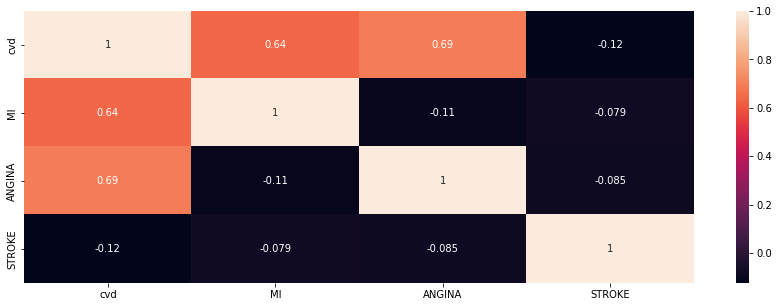

In [ ]:
#Matriz de correlação das features dos targets

correlacao = targets.corr()
plt.figure(figsize = (15,5))
sns.heatmap(correlacao, xticklabels=correlacao.columns, yticklabels=correlacao.columns, annot=True)

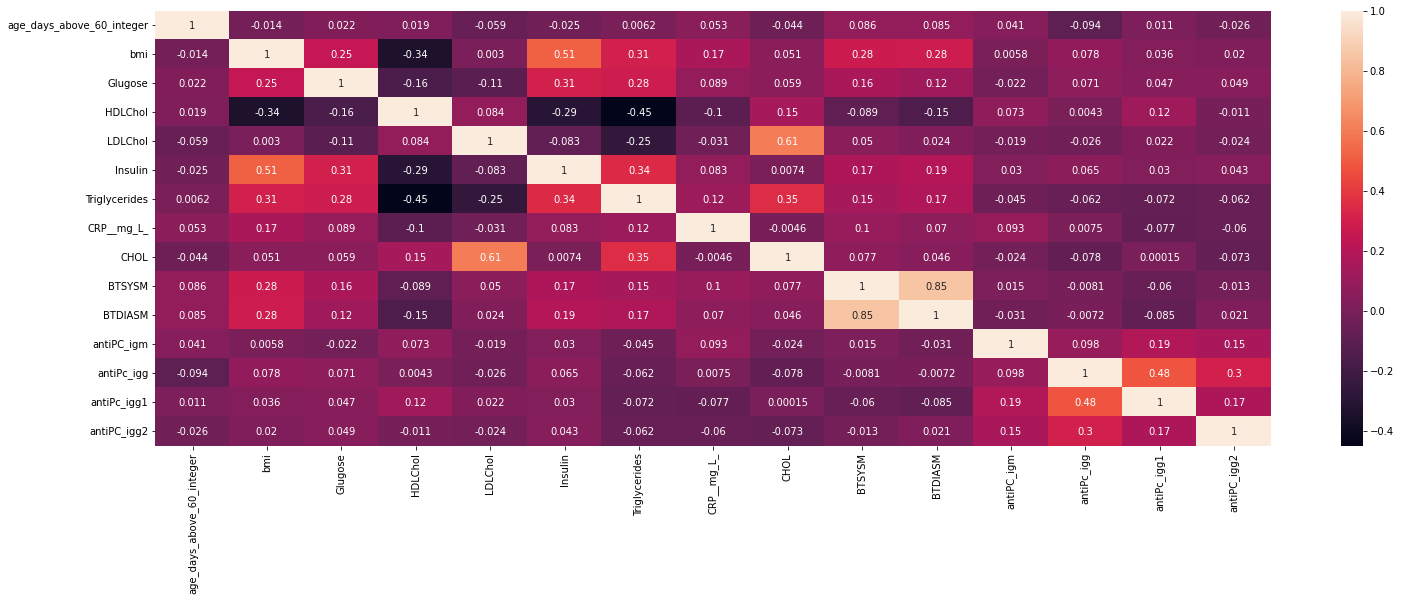

In [ ]:
#Matriz de correlação das features da base previsores

correlacao = previsores_cvd.corr()
plt.figure(figsize = (25,8))
sns.heatmap(correlacao, xticklabels=correlacao.columns, yticklabels=correlacao.columns, annot=True)

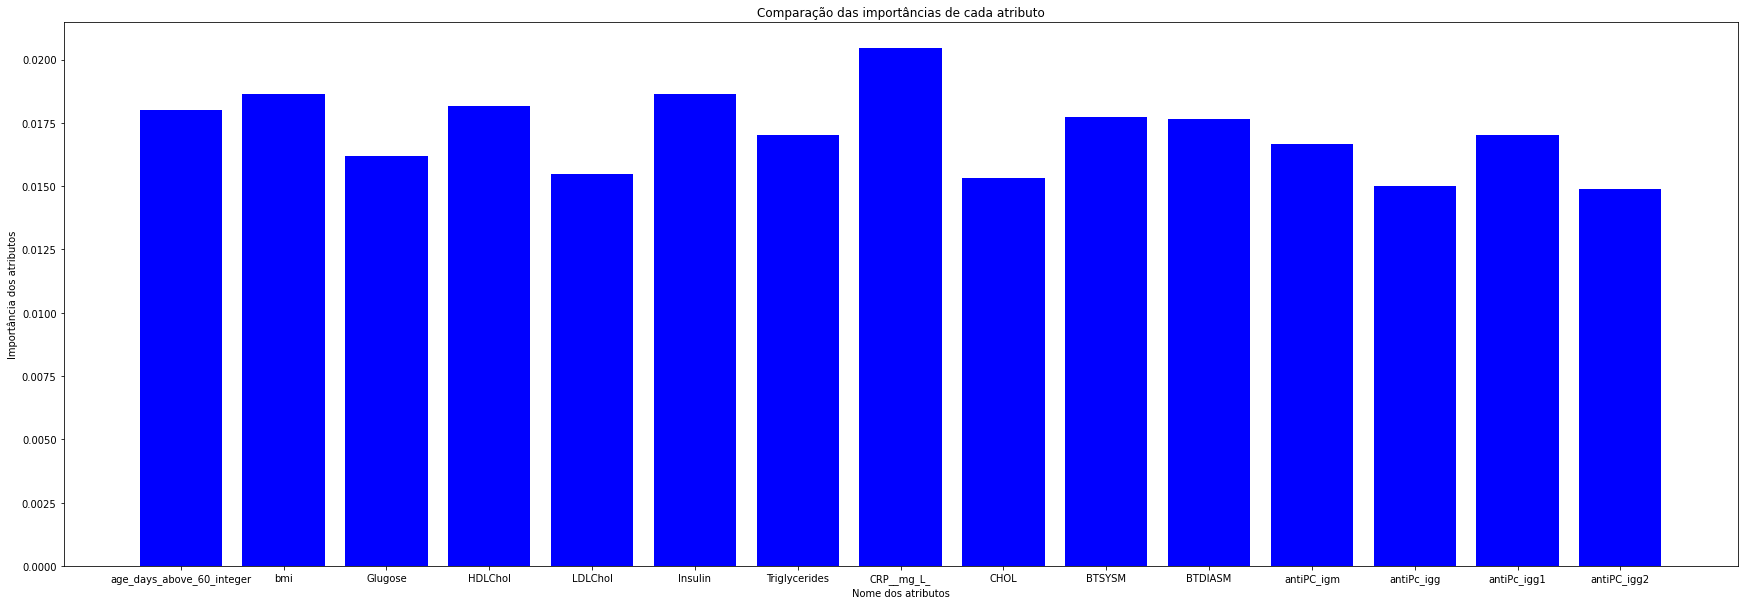

In [ ]:
#Comparação da importância das features da base previsores ajustada com a coluna target_cvd

features_importantes = ExtraTreesClassifier(n_estimators=250, random_state=420)
features_importantes.fit(previsores_cvd,target_cvd)

imp_features = features_importantes.feature_importances_
std = np.std([tree.feature_importances_ for tree in features_importantes.estimators_], axis = 0)
 
plt.figure(figsize = (30,10))
plt.bar(previsores_cvd.columns, std, color = 'blue') 
plt.xlabel('Nome dos atributos') 
plt.ylabel('Importância dos atributos') 
plt.title('Comparação das importâncias de cada atributo') 
plt.show()

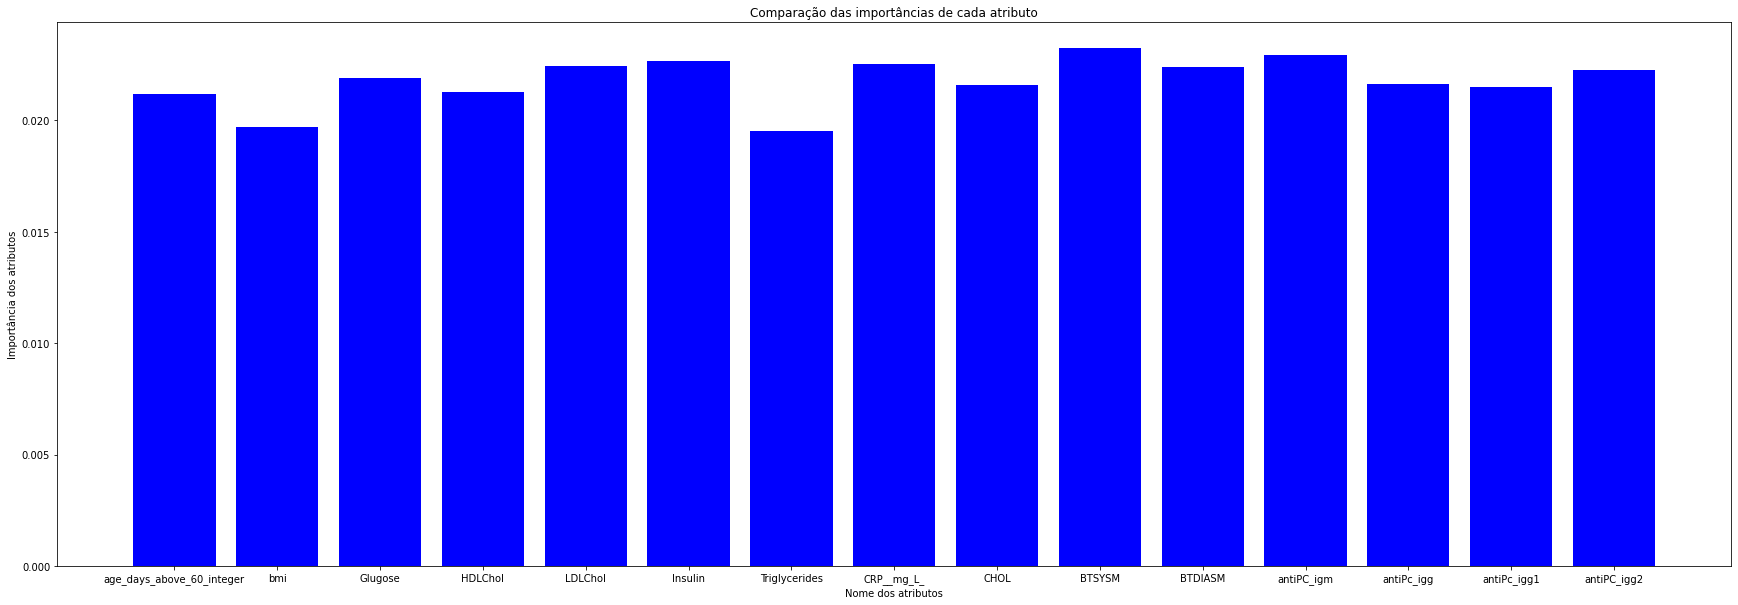

In [ ]:
#Comparação da importância das features da base previsores ajustada com a coluna target_MI

features_importantes = ExtraTreesClassifier(n_estimators=250, random_state=420)
features_importantes.fit(previsores_MI,target_MI)

imp_features = features_importantes.feature_importances_
std = np.std([tree.feature_importances_ for tree in features_importantes.estimators_], axis = 0)
 
plt.figure(figsize = (30,10))
plt.bar(previsores_MI.columns, std, color = 'blue') 
plt.xlabel('Nome dos atributos') 
plt.ylabel('Importância dos atributos') 
plt.title('Comparação das importâncias de cada atributo') 
plt.show()

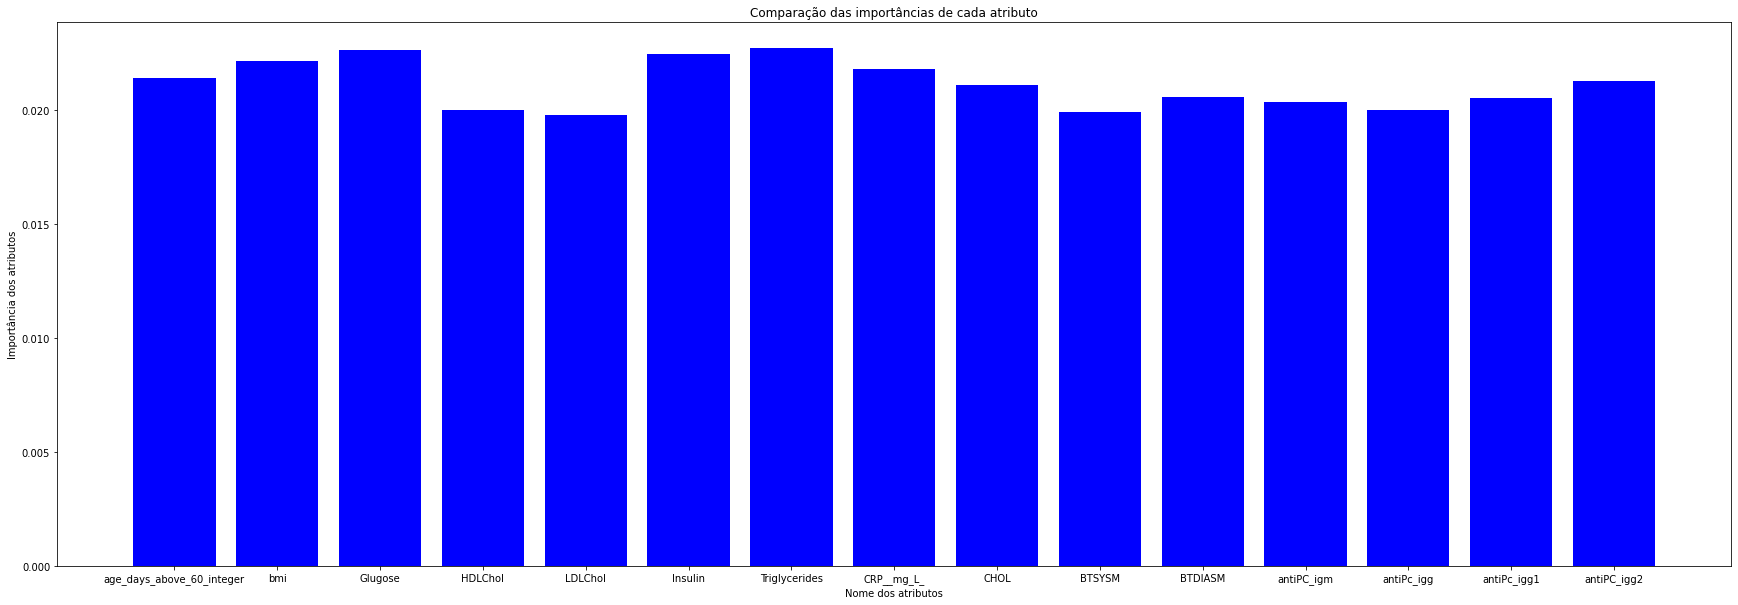

In [ ]:
#Comparação da importância das features da base previsores ajustada com a coluna target_ANGINA

features_importantes = ExtraTreesClassifier(n_estimators=250, random_state=420)
features_importantes.fit(previsores_ANGINA,target_ANGINA)

imp_features = features_importantes.feature_importances_
std = np.std([tree.feature_importances_ for tree in features_importantes.estimators_], axis = 0)
 
plt.figure(figsize = (30,10))
plt.bar(previsores_ANGINA.columns, std, color = 'blue') 
plt.xlabel('Nome dos atributos') 
plt.ylabel('Importância dos atributos') 
plt.title('Comparação das importâncias de cada atributo') 
plt.show()

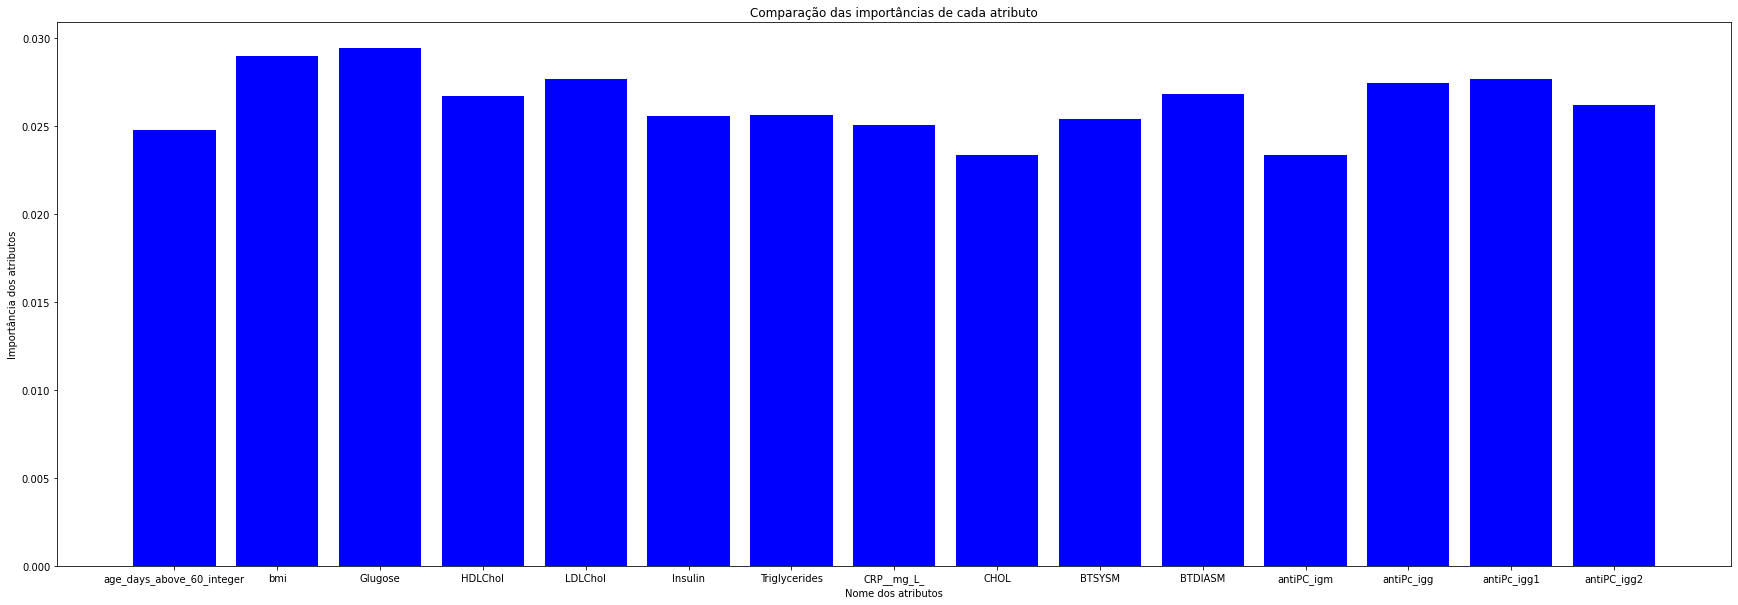

In [ ]:
#Comparação da importância das features da base previsores ajustada com a coluna target_STROKE

features_importantes = ExtraTreesClassifier(n_estimators=250, random_state=420)
features_importantes.fit(previsores_STROKE,target_STROKE)

imp_features = features_importantes.feature_importances_
std = np.std([tree.feature_importances_ for tree in features_importantes.estimators_], axis = 0)
 
plt.figure(figsize = (30,10))
plt.bar(previsores_STROKE.columns, std, color = 'blue') 
plt.xlabel('Nome dos atributos') 
plt.ylabel('Importância dos atributos') 
plt.title('Comparação das importâncias de cada atributo') 
plt.show()

**Visualização do desbalanceamento dos targets**

Text(0.5, 0.98, 'Dados de referência (target_cvd) antes de serem reamostrados com ADASYM')

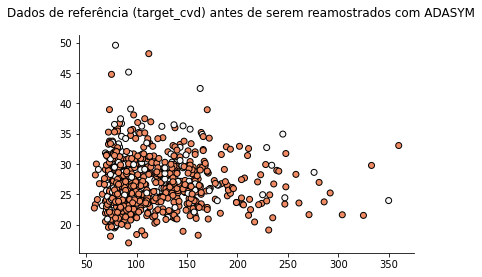

In [ ]:
#target_cvd

colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in target_cvd.values]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(previsores_cvd.values[:, 0], previsores_cvd.values[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Dados de referência (target_cvd) antes de serem reamostrados com ADASYM")

Text(0.5, 0.98, 'Dados de referência (target_MI) antes de serem reamostrados com ADASYM')

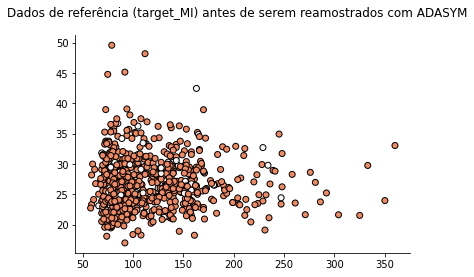

In [ ]:
#target_MI

colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in target_MI.values]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(previsores_MI.values[:, 0], previsores_MI.values[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Dados de referência (target_MI) antes de serem reamostrados com ADASYM")

Text(0.5, 0.98, 'Dados de referência (target_ANGINA) antes de serem reamostrados com ADASYM')

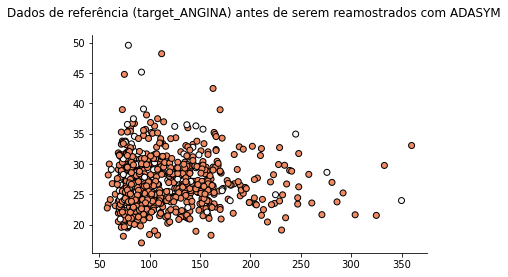

In [ ]:
#target_ANGINA

colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in target_ANGINA.values]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(previsores_ANGINA.values[:, 0], previsores_ANGINA.values[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Dados de referência (target_ANGINA) antes de serem reamostrados com ADASYM")

Text(0.5, 0.98, 'Dados de referência (target_STROKE) antes de serem reamostrados com ADASYM')

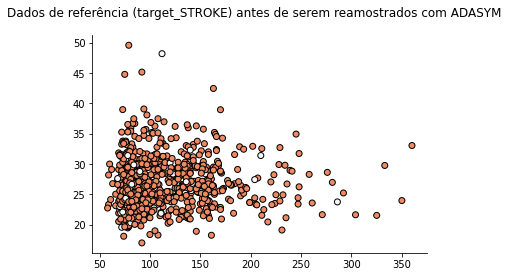

In [ ]:
#target_STROKE

colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in target_STROKE.values]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(previsores_STROKE.values[:, 0], previsores_STROKE.values[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Dados de referência (target_STROKE) antes de serem reamostrados com ADASYM")

**Balanceando os targets**

In [ ]:
# Definindo o número de vizinhos a serem considerados para cada amostra
# Através de testes, foi observado que o neighbors == 5 mostra um resultado melhor.

from math import ceil #arredonda um número para o número inteiro seguinte.

neighbors_cvd = ceil(sum(target_cvd) * 0.03)

neighbors_MI = ceil(sum(target_MI) * 0.06)

neighbors_ANGINA = ceil(sum(target_ANGINA) * 0.05)

neighbors_STROKE = ceil(sum(target_STROKE) * 0.1)

In [ ]:
#Importando a biblioteca de sobreamostragem para gerar dados sintéticos adaptáveis

from imblearn.over_sampling import ADASYN

In [ ]:
#Instanciando a função de sobreamostragem e passando o número de vizinhos a serem considerados para cada amostra

adasyn_cvd = ADASYN(sampling_strategy=1, n_neighbors=neighbors_cvd)
adasyn_MI = ADASYN(sampling_strategy=1, n_neighbors=neighbors_MI)
adasyn_ANGINA = ADASYN(sampling_strategy=1, n_neighbors=neighbors_ANGINA)
adasyn_STROKE = ADASYN(sampling_strategy=1, n_neighbors=neighbors_STROKE)

In [ ]:
#Gerando os dados sintéticos adaptáveis

previsores_cvd, target_cvd = adasyn_cvd.fit_resample(previsores_cvd, target_cvd)
previsores_MI, target_MI = adasyn_MI.fit_resample(previsores_MI, target_MI)
previsores_ANGINA, target_ANGINA = adasyn_ANGINA.fit_resample(previsores_ANGINA, target_ANGINA)
previsores_STROKE, target_STROKE = adasyn_STROKE.fit_resample(previsores_STROKE, target_STROKE)

**Visualizando os targets após o balanceaemento com ADASYM**

Text(0.5, 0.98, 'Dados de referência (target_cvd) reamostrados com ADASYM')

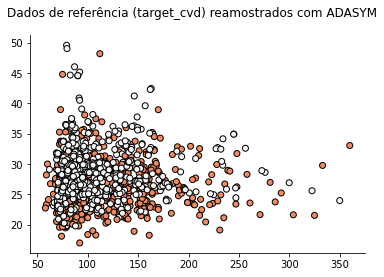

In [ ]:
#target_cvd

kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in target_cvd]
plt.scatter(previsores_cvd[:, 0], previsores_cvd[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Dados de referência (target_cvd) reamostrados com ADASYM")

Text(0.5, 0.98, 'Dados de referência (target_MI) reamostrados com ADASYM')

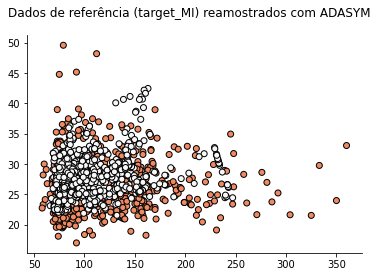

In [ ]:
#target_MI

kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in target_MI]
plt.scatter(previsores_MI[:, 0], previsores_MI[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Dados de referência (target_MI) reamostrados com ADASYM")

Text(0.5, 0.98, 'Dados de referência (target_ANGINA) reamostrados com ADASYM')

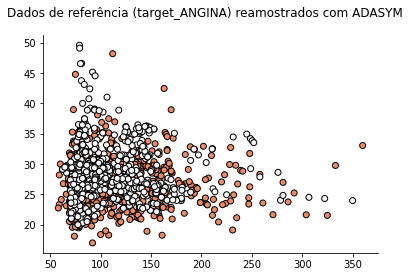

In [ ]:
#target_ANGINA

kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in target_ANGINA]
plt.scatter(previsores_ANGINA[:, 0], previsores_ANGINA[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Dados de referência (target_ANGINA) reamostrados com ADASYM")

Text(0.5, 0.98, 'Dados de referência (target_STROKE) reamostrados com ADASYM')

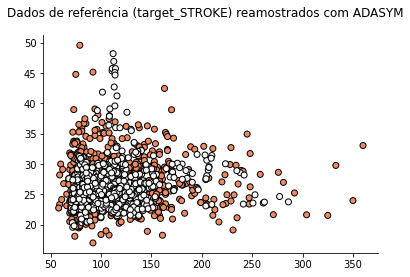

In [ ]:
#target_STROKE

kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in target_STROKE]
plt.scatter(previsores_STROKE[:, 0], previsores_STROKE[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Dados de referência (target_STROKE) reamostrados com ADASYM")

**Com o balanceamento, os datasets se transformaram em um array. Com isso, para facilitar a visualização, é necessário transformá-los novamente em DATAFRAME e nomear as colunas**

In [ ]:
previsores_cvd = pd.DataFrame(previsores_cvd)
target_cvd = pd.DataFrame(target_cvd)

target_cvd.columns = ['cvd']
previsores_cvd.columns = ['age_days_above_60_integer','bmi','Glugose','HDLChol','LDLChol','Insulin','Triglycerides','CRP__mg_L_','CHOL','BTSYSM','BTDIASM','antiPC_igm','antiPc_igg','antiPc_igg1','antiPC_igg2']

In [ ]:
previsores_cvd.shape, target_cvd.shape

((1309, 15), (1309, 1))

In [ ]:
previsores_MI = pd.DataFrame(previsores_MI)
target_MI = pd.DataFrame(target_MI)

target_MI.columns = ['MI']
previsores_MI.columns = ['age_days_above_60_integer','bmi','Glugose','HDLChol','LDLChol','Insulin','Triglycerides','CRP__mg_L_','CHOL','BTSYSM','BTDIASM','antiPC_igm','antiPc_igg','antiPc_igg1','antiPC_igg2']

In [ ]:
previsores_MI.shape, target_MI.shape

((1482, 15), (1482, 1))

In [ ]:
previsores_ANGINA = pd.DataFrame(previsores_ANGINA)
target_ANGINA = pd.DataFrame(target_ANGINA)

target_ANGINA.columns = ['ANGINA']
previsores_ANGINA.columns = ['age_days_above_60_integer','bmi','Glugose','HDLChol','LDLChol','Insulin','Triglycerides','CRP__mg_L_','CHOL','BTSYSM','BTDIASM','antiPC_igm','antiPc_igg','antiPc_igg1','antiPC_igg2']

In [ ]:
previsores_ANGINA.shape, target_ANGINA.shape

((1458, 15), (1458, 1))

In [ ]:
previsores_STROKE = pd.DataFrame(previsores_STROKE)
target_STROKE = pd.DataFrame(target_STROKE)

target_STROKE.columns = ['STROKE']
previsores_STROKE.columns = ['age_days_above_60_integer','bmi','Glugose','HDLChol','LDLChol','Insulin','Triglycerides','CRP__mg_L_','CHOL','BTSYSM','BTDIASM','antiPC_igm','antiPc_igg','antiPc_igg1','antiPC_igg2']

In [ ]:
previsores_STROKE.shape, target_STROKE.shape

((1540, 15), (1540, 1))

**Salvando em CSV os datasets balanceados**

In [ ]:
previsores_cvd.to_csv('previsores_cvd.csv')
target_cvd.to_csv('target_cvd.csv')

previsores_MI.to_csv('previsores_MI.csv')
target_MI.to_csv('target_MI.csv')

previsores_ANGINA.to_csv('previsores_ANGINA.csv')
target_ANGINA.to_csv('target_ANGINA.csv')

previsores_STROKE.to_csv('previsores_STROKE.csv')
target_STROKE.to_csv('target_STROKE.csv')

**Separando o Dataset em base de treinamento e teste**


In [ ]:
#Separando base previsores e target_cvd

X_train_cvd, X_test_cvd, y_train_cvd, y_test_cvd = train_test_split(previsores_cvd, target_cvd, test_size = 0.20)

#Separando base previsores e target_MI

X_train_MI, X_test_MI, y_train_MI, y_test_MI = train_test_split(previsores_MI, target_MI, test_size = 0.20)

#Separando base previsores e target_ANGINA

X_train_ANGINA, X_test_ANGINA, y_train_ANGINA, y_test_ANGINA = train_test_split(previsores_ANGINA, target_ANGINA, test_size = 0.20)

#Separando base previsores e target_STROKE

X_train_STROKE, X_test_STROKE, y_train_STROKE, y_test_STROKE = train_test_split(previsores_STROKE, target_STROKE, test_size = 0.20)

**Treinando o Dataset com o algoritmo RandomForestClassifier tendo como coluna a ser prevista a target_cvd**

In [ ]:
modeloRandom = RandomForestClassifier()
modeloRandom.fit(X_train_cvd, y_train_cvd)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# realizando predição na base de dados de teste previsores/target_cvd

previsoes_cvd = modeloRandom.predict(X_test_cvd)

Text(24.0, 0.5, 'Resposta Certa')

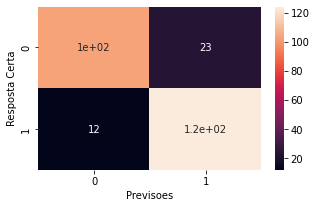

In [ ]:
# Matriz de confusão target_cvd

matriz_cvd = confusion_matrix(y_test_cvd, previsoes_cvd)

plt.figure(figsize = (5,3))
sns.heatmap(matriz_cvd, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_cvd

TP_cvd = matriz_cvd[0,0]
TN_cvd = matriz_cvd[1,1]
FP_cvd = matriz_cvd[1,0]
FN_cvd = matriz_cvd[0,1]

In [ ]:
#Accuracy previosres/target_cvd

Accuracy_cvd = accuracy_score(y_test_cvd, previsoes_cvd)

Accuracy_cvd

0.8664122137404581

In [ ]:
#F1_Score previsores/target_cvd

F1_cvd = f1_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

F1_cvd

0.8763250883392226

In [ ]:
#MCC_Score previsores/target_cvd

MCC_cvd = matthews_corrcoef(y_test_cvd, previsoes_cvd)

MCC_cvd

0.7341904011937023

In [ ]:
# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

sensitivity

0.8664122137404581

In [ ]:
# Specificity previsores/target_cvd

specificity_cvd = TN_cvd/(TN_cvd+FP_cvd)

specificity_cvd

0.9117647058823529

**Validação Cruzada**

In [ ]:
#Definindo os valores para folds

num_folds = 10
seed = 7

#Separando os dados em folds

Kfold = KFold(num_folds, True, random_state= seed) 

In [ ]:
#Criando o modelo

modeloRandomValCru = RandomForestClassifier()

**Validação Cruzada previsores e target_cvd usando o algoritmo RandomForestClassifier**

In [ ]:
#Aplicando a validação cruzada

resultados_acc_cvd = cross_val_score(modeloRandomValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='accuracy')
resultados_f1_cvd = cross_val_score(modeloRandomValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='f1')
resultados_recall_cvd = cross_val_score(modeloRandomValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='recall')
resultados_precision_cvd = cross_val_score(modeloRandomValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='precision')

In [ ]:
#Contagem das interações

cont = 0
k = []
for x in resultados_acc_cvd:
  k.append(f'{cont}º')
  cont += 1

<function matplotlib.pyplot.show>

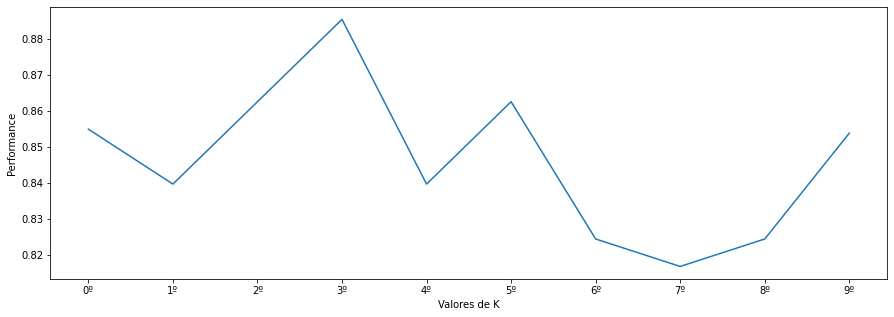

In [ ]:
#Accuracy previsores / target_cvd

plt.figure(figsize = (15,5))
plt.plot(k,resultados_acc_cvd)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

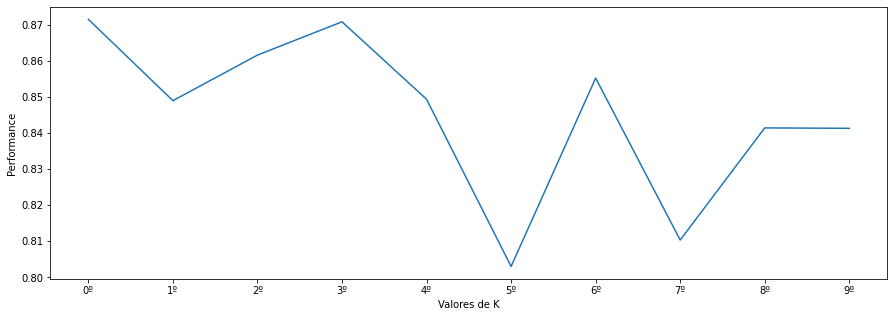

In [ ]:
#F1 previsores / target_cvd

plt.figure(figsize = (15,5))
plt.plot(k,resultados_f1_cvd)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

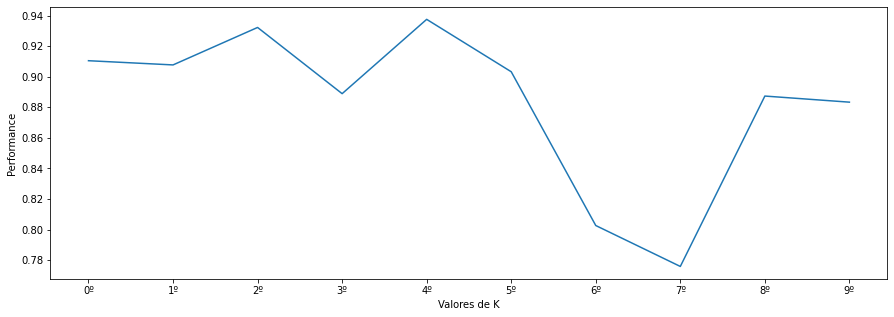

In [ ]:
#Recall(sensibility) previsores / target_cvd

plt.figure(figsize = (15,5))
plt.plot(k,resultados_recall_cvd)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

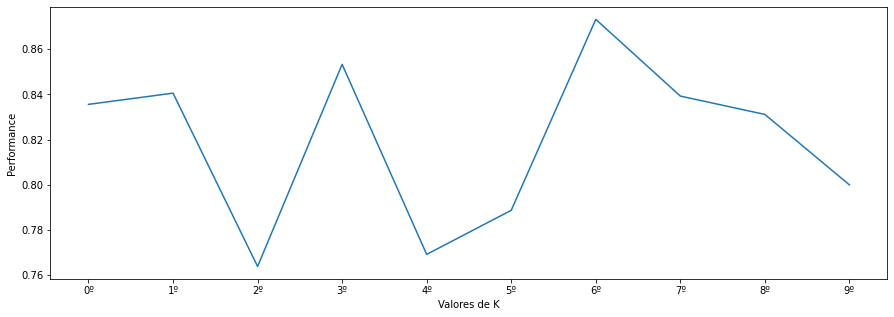

In [ ]:
#Precision previsores / target_cvd

plt.figure(figsize = (15,5))
plt.plot(k,resultados_precision_cvd)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_cvd = resultados_acc_cvd.mean() * 100
resultados_f1_cvd = resultados_f1_cvd.mean() * 100
resultados_recall_cvd = resultados_recall_cvd.mean() * 100
resultados_precision_cvd = resultados_precision_cvd.mean() * 100

print(f'Accuracy: {round(resultados_acc_cvd,2)} %\n\nF1: {round(resultados_f1_cvd,2)} %\n\nSensibility: {round(resultados_recall_cvd,2)} %\n\nPrecision: {round(resultados_precision_cvd,2)} %')

Accuracy: 84.65 %

F1: 84.53 %

Sensibility: 88.29 %

Precision: 81.95 %


**Treinando o Dataset com o algoritmo RandomForestClassifier tendo como coluna a ser prevista a target_MI**

In [ ]:
modeloRandom = RandomForestClassifier()
modeloRandom.fit(X_train_MI, y_train_MI)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# realizando predição na base de dados de teste previsores/target_MI

previsoes_MI = modeloRandom.predict(X_test_MI)

Text(24.0, 0.5, 'Resposta Certa')

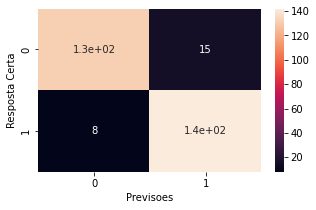

In [ ]:
# Matriz de confusão target_MI

matriz_MI = confusion_matrix(y_test_MI, previsoes_MI)

plt.figure(figsize = (5,3))
sns.heatmap(matriz_MI, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_MI

TP_MI = matriz_MI[0,0]
TN_MI = matriz_MI[1,1]
FP_MI = matriz_MI[1,0]
FN_MI = matriz_MI[0,1]

In [ ]:
#Accuracy previosres/target_MI

Accuracy_MI = accuracy_score(y_test_MI, previsoes_MI)

Accuracy_MI

0.9225589225589226

In [ ]:
#F1_Score previsores/target_MI

F1_MI = f1_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

F1_MI

0.9250814332247558

In [ ]:
#MCC_Score previsores/target_MI

MCC_MI = matthews_corrcoef(y_test_MI, previsoes_MI)

MCC_MI

0.8459697268468547

In [ ]:
# Sensitivity previsores/target_MI

sensitivity_MI = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

sensitivity_MI

0.9225589225589226

In [ ]:
# Specificity previsores/target_MI

specificity_MI = TN_MI/(TN_MI+FP_MI)

specificity_MI

0.9466666666666667

**Validação Cruzada previsores e target_MI usando o algoritmo 
RandomForestClassifier**

In [ ]:
#Aplicando a validação cruzada previsores / target_MI

resultados_acc_MI = cross_val_score(modeloRandomValCru, previsores_MI, target_MI, cv=Kfold, scoring='accuracy')
resultados_f1_MI = cross_val_score(modeloRandomValCru, previsores_MI, target_MI, cv=Kfold, scoring='f1')
resultados_recall_MI = cross_val_score(modeloRandomValCru, previsores_MI, target_MI, cv=Kfold, scoring='recall')
resultados_precision_MI = cross_val_score(modeloRandomValCru, previsores_MI, target_MI, cv=Kfold, scoring='precision')


<function matplotlib.pyplot.show>

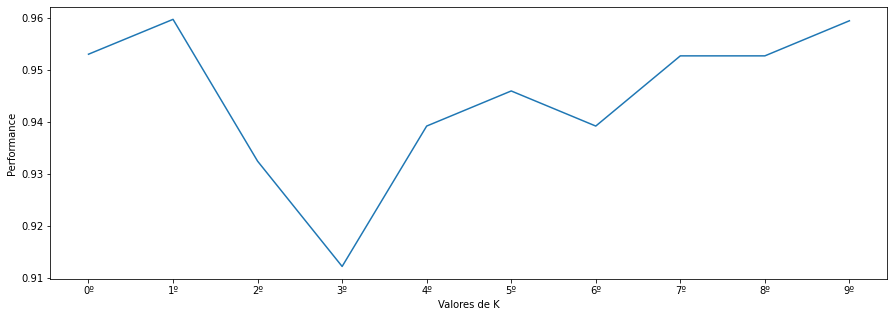

In [ ]:
#Accuracy previsores / target_MI

plt.figure(figsize = (15,5))
plt.plot(k,resultados_acc_MI)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

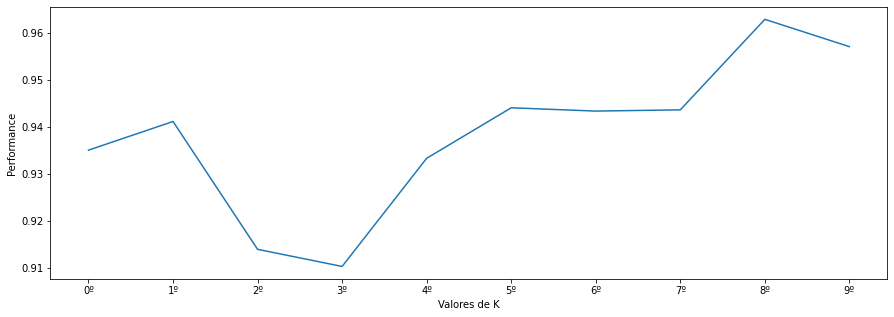

In [ ]:
#F1 previsores / target_MI

plt.figure(figsize = (15,5))
plt.plot(k,resultados_f1_MI)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

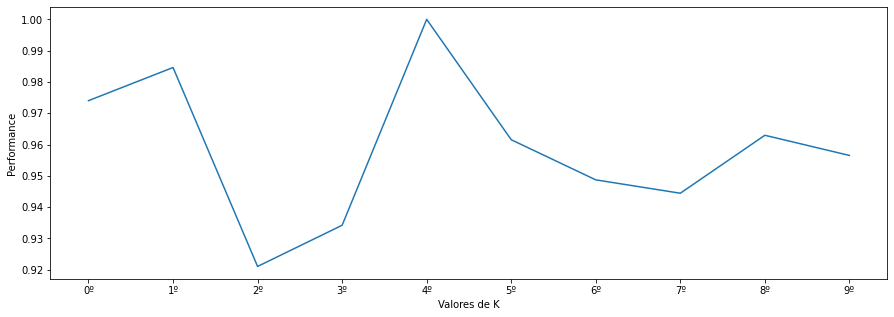

In [ ]:
#Recall(sensibility) previsores / target_MI

plt.figure(figsize = (15,5))
plt.plot(k,resultados_recall_MI)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

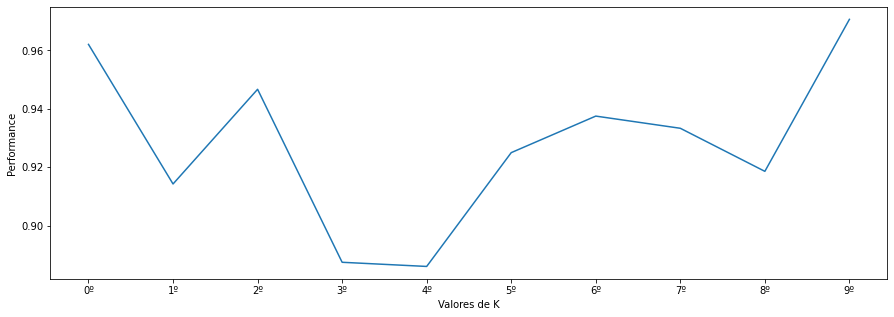

In [ ]:
#Precision previsores / target_MI

plt.figure(figsize = (15,5))
plt.plot(k,resultados_precision_MI)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_MI = resultados_acc_MI.mean() * 100
resultados_f1_MI = resultados_f1_MI.mean() * 100
resultados_recall_MI = resultados_recall_MI.mean() * 100
resultados_precision_MI = resultados_precision_MI.mean() * 100

print(f'Accuracy: {round(resultados_acc_MI,2)} %\n\nF1: {round(resultados_f1_MI,2)} %\n\nSensibility: {round(resultados_recall_MI,2)} %\n\nPrecision: {round(resultados_precision_MI,2)} %')

Accuracy: 94.47 %

F1: 93.85 %

Sensibility: 95.88 %

Precision: 92.82 %


**Treinando o Dataset com o algoritmo RandomForestClassifier tendo como coluna a ser prevista a target_ANGINA**

In [ ]:
modeloRandom = RandomForestClassifier()
modeloRandom.fit(X_train_ANGINA, y_train_ANGINA)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# realizando predição na base de dados de teste previsores/target_ANGINA

previsoes_ANGINA = modeloRandom.predict(X_test_ANGINA)

Text(24.0, 0.5, 'Resposta Certa')

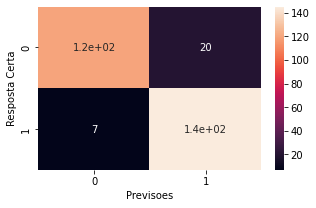

In [ ]:
# Matriz de confusão target_ANGINA

matriz_ANGINA = confusion_matrix(y_test_ANGINA, previsoes_ANGINA)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_ANGINA, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_ANGINA = matriz_ANGINA[0,0]
TN_ANGINA = matriz_ANGINA[1,1]
FP_ANGINA = matriz_ANGINA[1,0]
FN_ANGINA = matriz_ANGINA[0,1]

In [ ]:
#Accuracy previosres/target_ANGINA

Accuracy_ANGINA = accuracy_score(y_test_ANGINA, previsoes_ANGINA)

Accuracy_ANGINA

0.9075342465753424

In [ ]:
#F1_Score previsores/target_ANGINA

F1_ANGINA = f1_score(y_test_ANGINA, previsoes_ANGINA, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

F1_ANGINA

0.9148264984227129

In [ ]:
#MCC_Score previsores/target_AGINA

MCC_ANGINA = matthews_corrcoef(y_test_ANGINA, previsoes_ANGINA)

MCC_ANGINA

0.8173557966789847

In [ ]:
# Sensitivity previsores/target_ANGINA

sensitivity_ANGINA = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

sensitivity_ANGINA

0.9225589225589226

In [ ]:
# Specificity previsores/target_ANGINA

specificity_ANGINA = TN_ANGINA/(TN_ANGINA+FP_ANGINA)

specificity_ANGINA

0.9539473684210527

**Validação Cruzada previsores e target_ANGINA usando o algoritmo 
RandomForestClassifier**

In [ ]:
#Aplicando a validação cruzada previsores / target_ANGINA

resultados_acc_ANGINA = cross_val_score(modeloRandomValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='accuracy')
resultados_f1_ANGINA = cross_val_score(modeloRandomValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='f1')
resultados_recall_ANGINA = cross_val_score(modeloRandomValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='recall')
resultados_precision_ANGINA = cross_val_score(modeloRandomValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='precision')


<function matplotlib.pyplot.show>

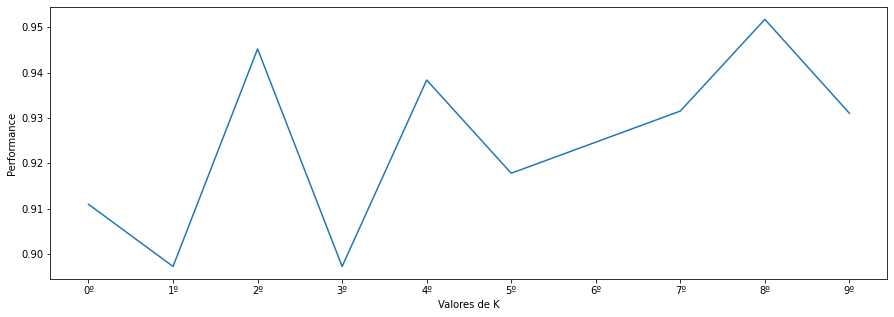

In [ ]:
#Accuracy previsores / target_ANGINA

plt.figure(figsize = (15,5))
plt.plot(k,resultados_acc_ANGINA)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

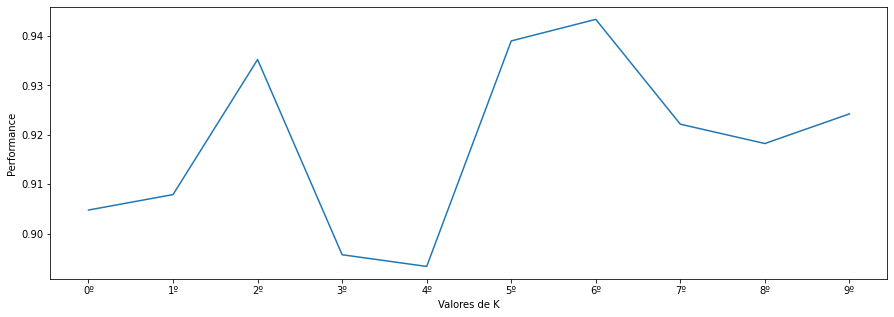

In [ ]:
#F1 previsores / target_ANGINA

plt.figure(figsize = (15,5))
plt.plot(k,resultados_f1_ANGINA)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

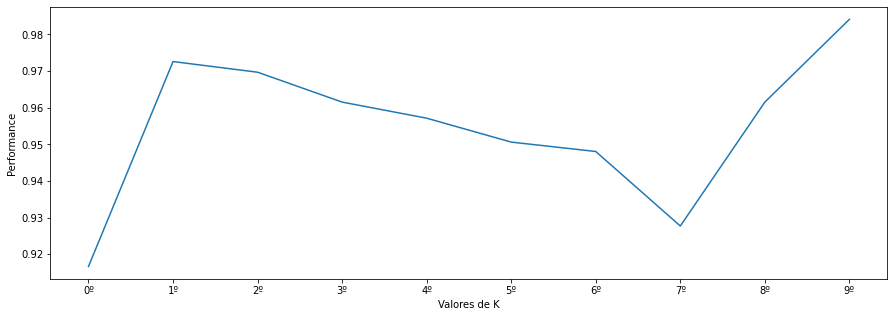

In [ ]:
#Recall(sensibility) previsores / target_ANGINA

plt.figure(figsize = (15,5))
plt.plot(k,resultados_recall_ANGINA)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

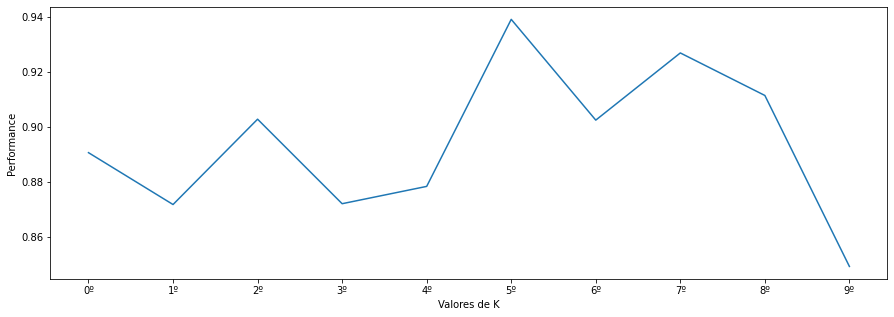

In [ ]:
#Precision previsores / target_AGINA

plt.figure(figsize = (15,5))
plt.plot(k,resultados_precision_ANGINA)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_ANGINA = resultados_acc_ANGINA.mean() * 100
resultados_f1_ANGINA = resultados_f1_ANGINA.mean() * 100
resultados_recall_ANGINA = resultados_recall_ANGINA.mean() * 100
resultados_precision_ANGINA = resultados_precision_ANGINA.mean() * 100

print(f'Accuracy: {round(resultados_acc_ANGINA,2)} %\n\nF1: {round(resultados_f1_ANGINA,2)} %\n\nSensibility: {round(resultados_recall_ANGINA,2)} %\n\nPrecision: {round(resultados_precision_ANGINA,2)} %')

Accuracy: 92.46 %

F1: 91.84 %

Sensibility: 95.5 %

Precision: 89.45 %


**Treinando o Dataset com o algoritmo RandomForestClassifier tendo como coluna a ser prevista a target_STROKE**

In [ ]:
modeloRandom = RandomForestClassifier(n_estimators=100)
modeloRandom.fit(X_train_STROKE, y_train_STROKE)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# realizando predição na base de dados de teste previsores/target_STROKE

previsoes_STROKE = modeloRandom.predict(X_test_STROKE)

Text(24.0, 0.5, 'Resposta Certa')

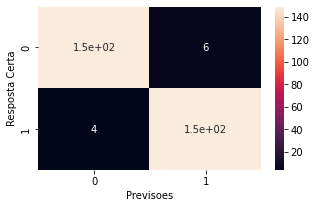

In [ ]:
# Matriz de confusão target_STROKE

matriz_STROKE = confusion_matrix(y_test_STROKE, previsoes_STROKE)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_STROKE, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_STROKE

TP_STROKE = matriz_STROKE[0,0]
TN_STROKE = matriz_STROKE[1,1]
FP_STROKE = matriz_STROKE[1,0]
FN_STROKE = matriz_STROKE[0,1]

In [ ]:
#Accuracy previosres/target_STROKE

Accuracy_STROKE = accuracy_score(y_test_STROKE, previsoes_STROKE)

Accuracy_STROKE

0.9675324675324676

In [ ]:
#F1_Score previsores/target_STROKE

F1_STROKE = f1_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

F1_STROKE

0.9675324675324675

In [ ]:
#MCC_Score previsores/target_STROKE

MCC_STROKE = matthews_corrcoef(y_test_STROKE, previsoes_STROKE)

MCC_STROKE

0.935146531730972

In [ ]:
# Sensitivity previsores/target_STROKE

sensitivity_STROKE = recall_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

sensitivity_STROKE

0.9675324675324676

In [ ]:
# Specificity previsores/target_STROKE

specificity_STROKE = TN_STROKE/(TN_STROKE+FP_STROKE)

specificity_STROKE

0.9738562091503268

**Validação Cruzada previsores e target_STROKE usando o algoritmo 
RandomForestClassifier**

In [ ]:
#Aplicando a validação cruzada previsores / target_STROKE

resultados_acc_STROKE = cross_val_score(modeloRandomValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='accuracy')
resultados_f1_STROKE = cross_val_score(modeloRandomValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='f1')
resultados_recall_STROKE = cross_val_score(modeloRandomValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='recall')
resultados_precision_STROKE = cross_val_score(modeloRandomValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='precision')

<function matplotlib.pyplot.show>

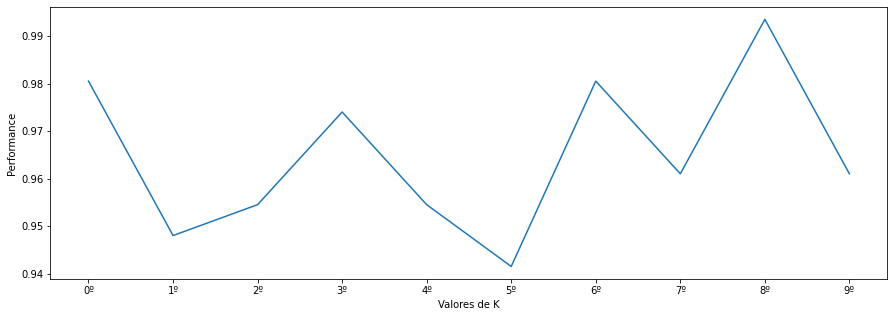

In [ ]:
#Accuracy previsores / target_STROKE

plt.figure(figsize = (15,5))
plt.plot(k,resultados_acc_STROKE)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

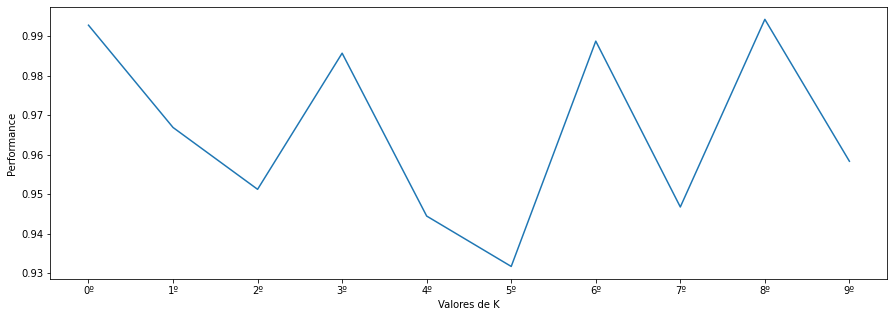

In [ ]:
#F1 previsores / target_STROKE

plt.figure(figsize = (15,5))
plt.plot(k,resultados_f1_STROKE)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

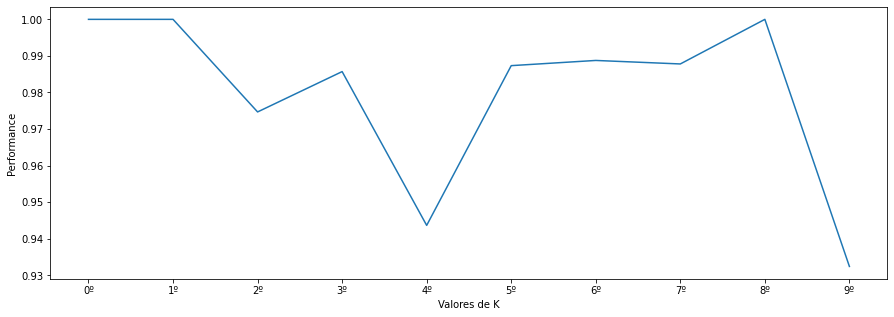

In [ ]:
#Recall(sensibility) previsores / target_STROKE

plt.figure(figsize = (15,5))
plt.plot(k,resultados_recall_STROKE)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

<function matplotlib.pyplot.show>

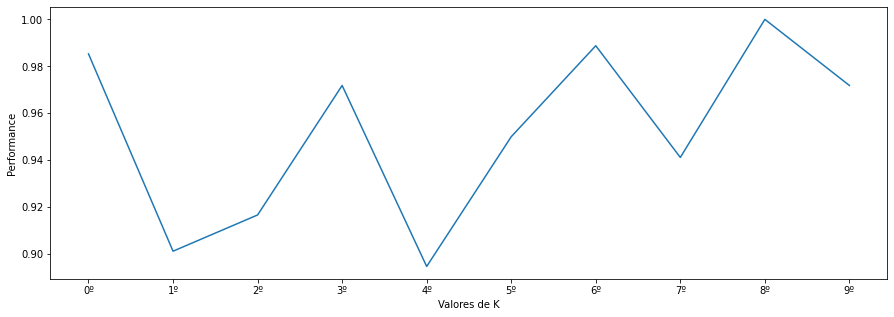

In [ ]:
#Precision previsores / target_STROKE

plt.figure(figsize = (15,5))
plt.plot(k,resultados_precision_STROKE)
plt.xlabel('Valores de K')
plt.ylabel('Performance')
plt.show

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_STROKE = resultados_acc_STROKE.mean() * 100
resultados_f1_STROKE = resultados_f1_STROKE.mean() * 100
resultados_recall_STROKE = resultados_recall_STROKE.mean() * 100
resultados_precision_STROKE = resultados_precision_STROKE.mean() * 100

print(f'Accuracy: {round(resultados_acc_STROKE,2)} %\n\nF1: {round(resultados_f1_STROKE,2)} %\n\nSensibility: {round(resultados_recall_STROKE,2)} %\n\nPrecision: {round(resultados_precision_STROKE,2)} %')

Accuracy: 96.49 %

F1: 96.61 %

Sensibility: 98.0 %

Precision: 95.22 %


**Treinando o Dataset com o algoritmo MultiOutputClassifier tendo como coluna a ser prevista a target_cvd**

In [ ]:
#O algoritmo MultiOutputClassifier apresentou erro ao tentarmos realizar o treinamento
#Aparentemente, a classe de saída não pode ter apenas um valor, quando queremos usar esse método
#Após alguns testes, fizemos a substituição pelo algoritmo KNeighborsClassifier

#modeloMulti = MultiOutputClassifier(estimator=XGBClassifier())

**Treinando o Dataset com o algoritmo KNeighborsClassifier tendo como coluna a ser prevista a target_cvd**

In [ ]:
modeloK = KNeighborsClassifier()

modeloK.fit(X_train_cvd, y_train_cvd)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
previsoes_cvd = modeloK.predict(X_test_cvd)

Text(24.0, 0.5, 'Resposta Certa')

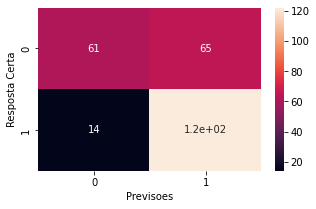

In [ ]:
# Matriz de confusão target_cvd

matriz_cvd = confusion_matrix(y_test_cvd, previsoes_cvd)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_cvd, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_cvd

TP_cvd = matriz_cvd[0,0]
TN_cvd = matriz_cvd[1,1]
FP_cvd = matriz_cvd[1,0]
FN_cvd = matriz_cvd[0,1]

#Accuracy previosres/target_cvd

Accuracy_cvd = accuracy_score(y_test_cvd, previsoes_cvd)

#F1_Score previsores/target_cvd

F1_cvd = f1_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

#MCC_Score previsores/target_cvd

MCC_cvd = matthews_corrcoef(y_test_cvd, previsoes_cvd)

# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

# Specificity previsores/target_cvd

specificity_cvd = TN_cvd/(TN_cvd+FP_cvd)

In [ ]:
print(f'Accuracy_cvd: {Accuracy_cvd}\n\nF1_cvd: {F1_cvd}\n\nMCC_cvd: {MCC_cvd}\n\nSensitivity_cvd: {sensitivity}\n\nSpecificity_cvd: {specificity_cvd}')

Accuracy_cvd: 0.6984732824427481

F1_cvd: 0.7554179566563469

MCC_cvd: 0.4213471050467854

Sensitivity_cvd: 0.6984732824427481

Specificity_cvd: 0.8970588235294118


**Treinando o Dataset com o algoritmo KNeighborsClassifier tendo como coluna a ser prevista a target_MI**

In [ ]:
modeloK.fit(X_train_MI, y_train_MI)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
previsoes_MI = modeloK.predict(X_test_MI)

Text(24.0, 0.5, 'Resposta Certa')

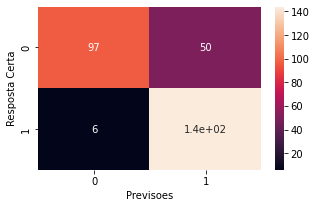

In [ ]:
# Matriz de confusão target_MI

matriz_MI = confusion_matrix(y_test_MI, previsoes_MI)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_MI, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_MI

TP_MI = matriz_MI[0,0]
TN_MI = matriz_MI[1,1]
FP_MI = matriz_MI[1,0]
FN_MI = matriz_MI[0,1]

#Accuracy previosres/target_MI

Accuracy_MI = accuracy_score(y_test_MI, previsoes_MI)

#F1_Score previsores/target_MI

F1_MI = f1_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

#MCC_Score previsores/target_MI

MCC_MI = matthews_corrcoef(y_test_MI, previsoes_MI)

# Sensitivity previsores/target_MI

sensitivity = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

# Specificity previsores/target_MI

specificity_MI = TN_MI/(TN_MI+FP_MI)

In [ ]:
print(f'Accuracy_MI: {Accuracy_MI}\n\nF1_MI: {F1_MI}\n\nMCC_MI: {MCC_MI}\n\nSensitivity_MI: {sensitivity}\n\nSpecificity_MI: {specificity_MI}')

Accuracy_MI: 0.8114478114478114

F1_MI: 0.8372093023255813

MCC_MI: 0.651150226417676

Sensitivity_MI: 0.8114478114478114

Specificity_MI: 0.96


**Treinando o Dataset com o algoritmo KNeighborsClassifier tendo como coluna a ser prevista a target_ANGINA**

In [ ]:
modeloK.fit(X_train_ANGINA, y_train_ANGINA)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
previsoes_ANGINA = modeloK.predict(X_test_ANGINA)

Text(24.0, 0.5, 'Resposta Certa')

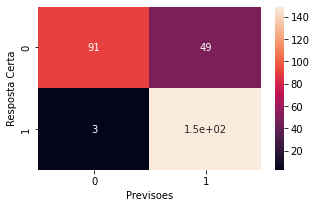

In [ ]:
# Matriz de confusão target_ANGINA

matriz_ANGINA = confusion_matrix(y_test_ANGINA, previsoes_ANGINA)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_ANGINA, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_ANGINA = matriz_ANGINA[0,0]
TN_ANGINA = matriz_ANGINA[1,1]
FP_ANGINA = matriz_ANGINA[1,0]
FN_ANGINA = matriz_ANGINA[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_ANGINA = accuracy_score(y_test_ANGINA, previsoes_ANGINA)

#F1_Score previsores/target_ANGINA

F1_ANGINA = f1_score(y_test_ANGINA, previsoes_ANGINA, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

#MCC_Score previsores/target_ANGINA

MCC_ANGINA = matthews_corrcoef(y_test_ANGINA, previsoes_ANGINA)

# Sensitivity previsores/target_ANGINA

sensitivity = recall_score(y_test_ANGINA, previsoes_ANGINA, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

# Specificity previsores/target_ANGINA

specificity_ANGINA = TN_ANGINA/(TN_ANGINA+FP_ANGINA)

In [ ]:
print(f'Accuracy_ANGINA: {Accuracy_ANGINA}\n\nF1_ANGINA: {F1_ANGINA}\n\nMCC_ANGINA: {MCC_ANGINA}\n\nSensitivity_ANGINA: {sensitivity}\n\nSpecificity_ANGINA: {specificity_ANGINA}')

Accuracy_ANGINA: 0.821917808219178

F1_ANGINA: 0.8514285714285714

MCC_ANGINA: 0.6739244471134442

Sensitivity_ANGINA: 0.821917808219178

Specificity_ANGINA: 0.9802631578947368


**Treinando o Dataset com o algoritmo KNeighborsClassifier tendo como coluna a ser prevista a target_STROKE**

In [ ]:
modeloK.fit(X_train_STROKE, y_train_STROKE)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
previsoes_STROKE = modeloK.predict(X_test_STROKE)

Text(24.0, 0.5, 'Resposta Certa')

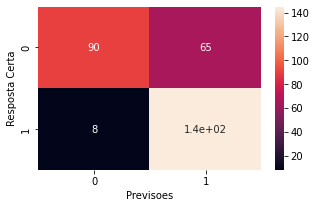

In [ ]:
# Matriz de confusão target_STROKE

matriz_STROKE = confusion_matrix(y_test_STROKE, previsoes_STROKE)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_STROKE, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_STROKE = matriz_STROKE[0,0]
TN_STROKE = matriz_STROKE[1,1]
FP_STROKE = matriz_STROKE[1,0]
FN_STROKE = matriz_STROKE[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_STROKE = accuracy_score(y_test_STROKE, previsoes_STROKE)

#F1_Score previsores/target_STROKE

F1_STROKE = f1_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

#MCC_Score previsores/target_STROKE

MCC_STROKE = matthews_corrcoef(y_test_STROKE, previsoes_STROKE)

# Sensitivity previsores/target_STROKE

sensitivity = recall_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

# Specificity previsores/target_STROKE

specificity_STROKE = TN_STROKE/(TN_STROKE+FP_STROKE)

In [ ]:
print(f'Accuracy_STROKE: {Accuracy_STROKE}\n\nF1_STROKE: {F1_STROKE}\n\nMCC_STROKE: {MCC_STROKE}\n\nSensitivity_STROKE: {sensitivity}\n\nSpecificity_STROKE: {specificity_STROKE}')

Accuracy_STROKE: 0.762987012987013

F1_STROKE: 0.7988980716253443

MCC_STROKE: 0.5671746624966416

Sensitivity_STROKE: 0.762987012987013

Specificity_STROKE: 0.9477124183006536



**Implementação do modelo de Rede Neural com camadas ocultas**

In [ ]:
#Criação da rede neural

modelo = Sequential()

In [ ]:
#Adicionando as camadas da Rede Neural

modelo.add(Dense(units=8, activation='relu', input_dim = 15)) # Camada de entrada
modelo.add(Dropout(0.3))

modelo.add(Dense(units=8, activation='relu')) # Camada oculta
modelo.add(Dropout(0.2))

modelo.add(Dense(units=8, activation='relu')) # Camada oculta
modelo.add(Dropout(0.2))

modelo.add(Dense(units=1, activation='sigmoid')) # Camada de saída

In [ ]:
#Compilando a Rede Neural

modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

**Treinando a rede neural com as bases previsores/target_cvd**

In [ ]:
#Efetuando o treinamento da Rede Neural

modelo.fit(X_train_cvd, y_train_cvd, epochs=100, batch_size=10)

#Realizando previsão com a base de dado de teste

previsoes_cvd = modelo.predict(X_test_cvd)

#Convertendo os resultados em True ou False

previsoes_cvd = (previsoes_cvd > 0.5)

Epoch 1/100
105/105 [==============================] - 1s 1ms/step - loss: 12.5029 - binary_accuracy: 0.5005
Epoch 2/100
105/105 [==============================] - 0s 2ms/step - loss: 3.1387 - binary_accuracy: 0.5014
Epoch 3/100
105/105 [==============================] - 0s 2ms/step - loss: 1.8392 - binary_accuracy: 0.5081
Epoch 4/100
105/105 [==============================] - 0s 1ms/step - loss: 1.7231 - binary_accuracy: 0.4852
Epoch 5/100
105/105 [==============================] - 0s 2ms/step - loss: 1.1943 - binary_accuracy: 0.4976
Epoch 6/100
105/105 [==============================] - 0s 1ms/step - loss: 1.1062 - binary_accuracy: 0.4938
Epoch 7/100
105/105 [==============================] - 0s 1ms/step - loss: 0.9931 - binary_accuracy: 0.5129
Epoch 8/100
105/105 [==============================] - 0s 1ms/step - loss: 0.8738 - binary_accuracy: 0.4928
Epoch 9/100
105/105 [==============================] - 0s 1ms/step - loss: 0.8473 - binary_accuracy: 0.5043
Epoch 10/100
105/105 [=====

Text(24.0, 0.5, 'Resposta Certa')

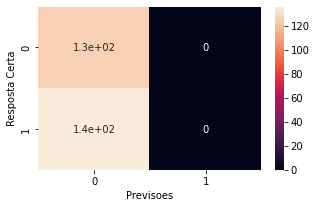

In [ ]:
# Matriz de confusão target_cvd

matriz_cvd = confusion_matrix(y_test_cvd, previsoes_cvd)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_cvd, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_cvd

TP_cvd = matriz_cvd[0,0]
TN_cvd = matriz_cvd[1,1]
FP_cvd = matriz_cvd[1,0]
FN_cvd = matriz_cvd[0,1]

#Accuracy previosres/target_cvd

Accuracy_cvd = accuracy_score(y_test_cvd, previsoes_cvd)

#F1_Score previsores/target_cvd

F1_cvd = f1_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

#MCC_Score previsores/target_cvd

MCC_cvd = matthews_corrcoef(y_test_cvd, previsoes_cvd)

# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

# Specificity previsores/target_cvd

specificity_cvd = TN_cvd/(TN_cvd+FP_cvd)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
print(f'Accuracy_cvd: {Accuracy_cvd}\n\nF1_cvd: {F1_cvd}\n\nMCC_cvd: {MCC_cvd}\n\nSensitivity_cvd: {sensitivity}\n\nSpecificity_cvd: {specificity_cvd}')

Accuracy_cvd: 0.48091603053435117

F1_cvd: 0.0

MCC_cvd: 0.0

Sensitivity_cvd: 0.48091603053435117

Specificity_cvd: 0.0


**Treinando a rede neural com as bases previsores/target_MI**

In [ ]:
#Efetuando o treinamento da Rede Neural

modelo.fit(X_train_MI, y_train_MI, epochs=100, batch_size=10)

#Realizando previsão com a base de dado de teste

previsoes_MI = modelo.predict(X_test_MI)

#Convertendo os resultados em True ou False

previsoes_MI = (previsoes_MI > 0.5)

Epoch 1/100
119/119 [==============================] - 0s 1ms/step - loss: 0.6936 - binary_accuracy: 0.5004
Epoch 2/100
119/119 [==============================] - 0s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4979
Epoch 3/100
119/119 [==============================] - 0s 1ms/step - loss: 0.6930 - binary_accuracy: 0.5021
Epoch 4/100
119/119 [==============================] - 0s 2ms/step - loss: 0.6953 - binary_accuracy: 0.4911
Epoch 5/100
119/119 [==============================] - 0s 2ms/step - loss: 0.6940 - binary_accuracy: 0.4886
Epoch 6/100
119/119 [==============================] - 0s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4911
Epoch 7/100
119/119 [==============================] - 0s 1ms/step - loss: 0.6933 - binary_accuracy: 0.4852
Epoch 8/100
119/119 [==============================] - 0s 1ms/step - loss: 0.6925 - binary_accuracy: 0.5105
Epoch 9/100
119/119 [==============================] - 0s 1ms/step - loss: 0.6933 - binary_accuracy: 0.4945
Epoch 10/100
119/119 [======

Text(24.0, 0.5, 'Resposta Certa')

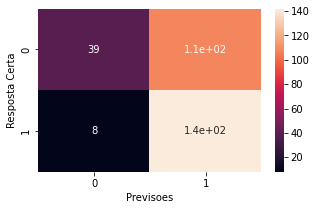

In [ ]:
# Matriz de confusão target_MI

matriz_MI = confusion_matrix(y_test_MI, previsoes_MI)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_MI, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_MI

TP_MI = matriz_MI[0,0]
TN_MI = matriz_MI[1,1]
FP_MI = matriz_MI[1,0]
FN_MI = matriz_MI[0,1]

#Accuracy previosres/target_MI

Accuracy_MI = accuracy_score(y_test_MI, previsoes_MI)

#F1_Score previsores/target_MI

F1_MI = f1_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

#MCC_Score previsores/target_MI

MCC_MI = matthews_corrcoef(y_test_MI, previsoes_MI)

# Sensitivity previsores/target_MI

sensitivity = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

# Specificity previsores/target_MI

specificity_MI = TN_MI/(TN_MI+FP_MI)

In [ ]:
print(f'Accuracy_MI: {Accuracy_MI}\n\nF1_MI: {F1_MI}\n\nMCC_MI: {MCC_MI}\n\nSensitivity_MI: {sensitivity}\n\nSpecificity_MI: {specificity_MI}')

Accuracy_MI: 0.6094276094276094

F1_MI: 0.7100000000000001

MCC_MI: 0.2903791822335037

Sensitivity_MI: 0.6094276094276094

Specificity_MI: 0.9466666666666667


**Treinando a rede neural com as bases previsores/target_ANGINA**

In [ ]:
#Efetuando o treinamento da Rede Neural

modelo.fit(X_train_ANGINA, y_train_ANGINA, epochs=100, batch_size=10)

#Realizando previsão com a base de dado de teste

previsoes_ANGINA = modelo.predict(X_test_ANGINA)

#Convertendo os resultados em True ou False

previsoes_ANGINA = (previsoes_ANGINA > 0.5)

Epoch 1/100
117/117 [==============================] - 0s 1ms/step - loss: 0.7264 - binary_accuracy: 0.5172
Epoch 2/100
117/117 [==============================] - 0s 1ms/step - loss: 0.6936 - binary_accuracy: 0.5146
Epoch 3/100
117/117 [==============================] - 0s 1ms/step - loss: 0.6894 - binary_accuracy: 0.5249
Epoch 4/100
117/117 [==============================] - 0s 2ms/step - loss: 0.6837 - binary_accuracy: 0.5240
Epoch 5/100
117/117 [==============================] - 0s 1ms/step - loss: 0.6896 - binary_accuracy: 0.5214
Epoch 6/100
117/117 [==============================] - 0s 1ms/step - loss: 0.6811 - binary_accuracy: 0.5249
Epoch 7/100
117/117 [==============================] - 0s 1ms/step - loss: 0.6821 - binary_accuracy: 0.5206
Epoch 8/100
117/117 [==============================] - 0s 1ms/step - loss: 0.6802 - binary_accuracy: 0.5172
Epoch 9/100
117/117 [==============================] - 0s 1ms/step - loss: 0.6778 - binary_accuracy: 0.5240
Epoch 10/100
117/117 [======

Text(24.0, 0.5, 'Resposta Certa')

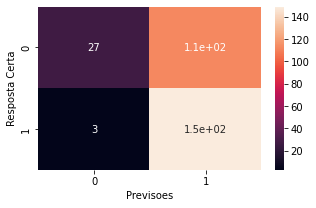

In [ ]:
# Matriz de confusão target_ANGINA

matriz_ANGINA = confusion_matrix(y_test_ANGINA, previsoes_ANGINA)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_ANGINA, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_ANGINA = matriz_ANGINA[0,0]
TN_ANGINA = matriz_ANGINA[1,1]
FP_ANGINA = matriz_ANGINA[1,0]
FN_ANGINA = matriz_ANGINA[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_ANGINA = accuracy_score(y_test_ANGINA, previsoes_ANGINA)

#F1_Score previsores/target_ANGINA

F1_ANGINA = f1_score(y_test_ANGINA, previsoes_ANGINA, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

#MCC_Score previsores/target_ANGINA

MCC_ANGINA = matthews_corrcoef(y_test_ANGINA, previsoes_ANGINA)

# Sensitivity previsores/target_ANGINA

sensitivity = recall_score(y_test_ANGINA, previsoes_ANGINA, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

# Specificity previsores/target_ANGINA

specificity_ANGINA = TN_ANGINA/(TN_ANGINA+FP_ANGINA)

In [ ]:
print(f'Accuracy_ANGINA: {Accuracy_ANGINA}\n\nF1_ANGINA: {F1_ANGINA}\n\nMCC_ANGINA: {MCC_ANGINA}\n\nSensitivity_ANGINA: {sensitivity}\n\nSpecificity_ANGINA: {specificity_ANGINA}')

Accuracy_ANGINA: 0.6027397260273972

F1_ANGINA: 0.7198067632850242

MCC_ANGINA: 0.2848541406072765

Sensitivity_ANGINA: 0.6027397260273972

Specificity_ANGINA: 0.9802631578947368


**Treinando a rede neural com as bases previsores/target_STROKE**

In [ ]:
#Efetuando o treinamento da Rede Neural

modelo.fit(X_train_STROKE, y_train_STROKE, epochs=100, batch_size=10)

#Realizando previsão com a base de dado de teste

previsoes_STROKE = modelo.predict(X_test_STROKE)

#Convertendo os resultados em True ou False

previsoes_STROKE = (previsoes_STROKE > 0.5)

Epoch 1/100
124/124 [==============================] - 0s 1ms/step - loss: 0.7677 - binary_accuracy: 0.5219
Epoch 2/100
124/124 [==============================] - 0s 1ms/step - loss: 0.6961 - binary_accuracy: 0.5211
Epoch 3/100
124/124 [==============================] - 0s 1ms/step - loss: 0.6908 - binary_accuracy: 0.5349
Epoch 4/100
124/124 [==============================] - 0s 1ms/step - loss: 0.6787 - binary_accuracy: 0.5430
Epoch 5/100
124/124 [==============================] - 0s 2ms/step - loss: 0.6755 - binary_accuracy: 0.5495
Epoch 6/100
124/124 [==============================] - 0s 1ms/step - loss: 0.6720 - binary_accuracy: 0.5519
Epoch 7/100
124/124 [==============================] - 0s 1ms/step - loss: 0.6796 - binary_accuracy: 0.5511
Epoch 8/100
124/124 [==============================] - 0s 1ms/step - loss: 0.6831 - binary_accuracy: 0.5455
Epoch 9/100
124/124 [==============================] - 0s 1ms/step - loss: 0.6710 - binary_accuracy: 0.5544
Epoch 10/100
124/124 [======

Text(24.0, 0.5, 'Resposta Certa')

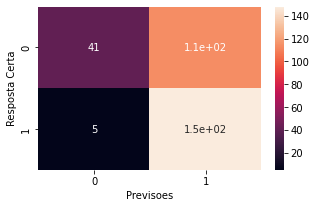

In [ ]:
# Matriz de confusão target_STROKE

matriz_STROKE = confusion_matrix(y_test_STROKE, previsoes_STROKE)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_STROKE, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_STROKE = matriz_STROKE[0,0]
TN_STROKE = matriz_STROKE[1,1]
FP_STROKE = matriz_STROKE[1,0]
FN_STROKE = matriz_STROKE[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_STROKE = accuracy_score(y_test_STROKE, previsoes_STROKE)

#F1_Score previsores/target_STROKE

F1_STROKE = f1_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

#MCC_Score previsores/target_STROKE

MCC_STROKE = matthews_corrcoef(y_test_STROKE, previsoes_STROKE)

# Sensitivity previsores/target_STROKE

sensitivity = recall_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

# Specificity previsores/target_STROKE

specificity_STROKE = TN_STROKE/(TN_STROKE+FP_STROKE)

In [ ]:
print(f'Accuracy_STROKE: {Accuracy_STROKE}\n\nF1_STROKE: {F1_STROKE}\n\nMCC_STROKE: {MCC_STROKE}\n\nSensitivity_STROKE: {sensitivity}\n\nSpecificity_STROKE: {specificity_STROKE}')

Accuracy_STROKE: 0.6136363636363636

F1_STROKE: 0.7132530120481929

MCC_STROKE: 0.32520978891211566

Sensitivity_STROKE: 0.6136363636363636

Specificity_STROKE: 0.9673202614379085
